# Speed-dependent Analysis of Walking on the Linear Treadmill
## Brandon Pratt, 04/02/2021

Characterize intralimb kinematics and interlimb coordination of flies with and without pertubed proprioception as a function of walking speed

### Import Python Libraries

In [1]:
import os
from os import listdir
from os.path import isfile, join
import math

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal

from scipy import signal
from scipy.stats import norm
import dabest
from scipy.stats import vonmises
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d

### Organize tracked body and leg positions

Also, align the fly to a common heading

In [2]:
def org_data(DF):
    df=DF
    headers = df.columns.values.tolist() # column headers
    chamber_frontx = df[headers[0:1][0]][0]
    chamber_backx = df[headers[12:13][0]][0]
    chamber_length=chamber_frontx-chamber_backx
    # determine if there needs to be a correction factor
    true_chamber_length=8.929 # known chamber length
#     chamber_length=2.255
    correction_val=true_chamber_length/chamber_length # convert the tracked positions to actual positions    
    
    head = df[headers[18:21]] * correction_val
    thorax = df[headers[24:27]] * correction_val
    abdomen = df[headers[30:33]] * correction_val
    r1_raw = df[headers[36:39]] * correction_val
    r2_raw = df[headers[42:45]] * correction_val
    r3_raw = df[headers[48:51]] * correction_val
    
    # normalize these to the thorax (~center of mass)
    r1 = r1_raw - thorax.values.astype(float)
    r2 = r2_raw - thorax.values.astype(float)
    r3 = r3_raw - thorax.values.astype(float)
    
    # left legs
    l1_raw = df[headers[54:57]] * correction_val
    l2_raw = df[headers[60:63]] * correction_val
    l3_raw = df[headers[66:69]] * correction_val

    # normalize these to the thorax (~center of mass)
    l1 = l1_raw - thorax.values.astype(float)
    l2 = l2_raw - thorax.values.astype(float)
    l3 = l3_raw - thorax.values.astype(float)
    
    # seperate legs into there own dimensions
    # isolate the x position only of the legs
    r1_x=r1[r1.columns[0]]
    r2_x=r2[r2.columns[0]]
    r3_x=r3[r3.columns[0]]
    l1_x=l1[l1.columns[0]]
    l2_x=l2[l2.columns[0]]
    l3_x=l3[l3.columns[0]]
    
    x_pos_raw=[r1_x, r2_x, r3_x, l1_x, l2_x, l3_x]

    # isolate the y position only of the legs
    r1_y=r1[r1.columns[1]]
    r2_y=r2[r2.columns[1]]
    r3_y=r3[r3.columns[1]]
    l1_y=l1[l1.columns[1]]
    l2_y=l2[l2.columns[1]]
    l3_y=l3[l3.columns[1]]
    
    y_pos_raw=[r1_y, r2_y, r3_y, l1_y, l2_y, l3_y]
    
    # isolate the x position only of the legs
    r1_z=r1[r1.columns[2]]
    r2_z=r2[r2.columns[2]]
    r3_z=r3[r3.columns[2]]
    l1_z=l1[l1.columns[2]]
    l2_z=l2[l2.columns[2]]
    l3_z=l3[l3.columns[2]]
    
    z_pos=[r1_z, r2_z, r3_z, l1_z, l2_z, l3_z]
    
    # transform the data so that the fly is superimposed on itself
    [x_pos, y_pos]=coordinate_transform(x_pos_raw, y_pos_raw, thorax, head, abdomen)
    
#     # plot the fly
#     frame = 1509
#     hx = head['head_x'][frame]
#     hy = head['head_y'][frame]
#     plt.figure(1, figsize = [10, 10])
#     plt.plot(np.array([0, hx]), np.array([0, hy]), color = 'black')
#     plt.plot(r1_x[frame], r1_y[frame], linestyle = 'none', marker ='.', color = 'red', markersize = 15)
#     plt.plot(r2_x[frame], r2_y[frame], linestyle = 'none', marker ='.', color = 'salmon', markersize = 15)
#     plt.plot(r3_x[frame], r3_y[frame], linestyle = 'none', marker ='.', color = 'lightsalmon', markersize = 15)
#     plt.plot(l1_x[frame], l1_y[frame], linestyle = 'none', marker ='.', color = 'blue', markersize = 15)
#     plt.plot(l2_x[frame], l3_y[frame], linestyle = 'none', marker ='.', color = 'steelblue', markersize = 15)
#     plt.plot(l3_x[frame], l3_y[frame], linestyle = 'none', marker ='.', color = 'lightsteelblue', markersize = 15)
#     plt.legend(['Heading','R1', 'R2', 'R3', 'L1', 'L2', 'L3'])
    
#     plt.figure(2, figsize = [10, 10])
#     plt.plot(np.array([0, 1]), np.array([0, 0]), color = 'black')
#     plt.plot(x_pos[0][frame], y_pos[0][frame], linestyle = 'none', marker ='.', color = 'red', markersize = 15)
#     plt.plot(x_pos[1][frame], y_pos[1][frame], linestyle = 'none', marker ='.', color = 'salmon', markersize = 15)
#     plt.plot(x_pos[2][frame], y_pos[2][frame], linestyle = 'none', marker ='.', color = 'lightsalmon', markersize = 15)
#     plt.plot(x_pos[3][frame], y_pos[3][frame], linestyle = 'none', marker ='.', color = 'blue', markersize = 15)
#     plt.plot(x_pos[4][frame], y_pos[4][frame], linestyle = 'none', marker ='.', color = 'steelblue', markersize = 15)
#     plt.plot(x_pos[5][frame], y_pos[5][frame], linestyle = 'none', marker ='.', color = 'lightsteelblue', markersize = 15)
#     plt.legend(['Heading', 'R1', 'R2', 'R3', 'L1', 'L2', 'L3'])
     
    return head, thorax, abdomen, x_pos, y_pos, z_pos

### Align fly to a common heading angle

In [3]:
def coordinate_transform(x_pos, y_pos, thorax, head, abdomen):

    # extract data and adjust for the mirroring in y
    r1_x = x_pos[0]
    r1_y = -y_pos[0] 

    r2_x = x_pos[1]
    r2_y = -y_pos[1] 

    r3_x = x_pos[2]
    r3_y = -y_pos[2] 

    l1_x = x_pos[3]
    l1_y = -y_pos[3] 

    l2_x = x_pos[4]
    l2_y = -y_pos[4] 

    l3_x = x_pos[5]
    l3_y = -y_pos[5] 

    # body position
    tx=thorax['thorax_x'] 
    ty=thorax['thorax_y'] 

    hx=np.array(head['head_x'] - tx.values.astype(float))
    hy=-(np.array(head['head_y'] - ty.values.astype(float)))

    ax=abdomen['abdomen_x'] - tx.values.astype(float)
    ay=-(abdomen['abdomen_y'] - ty.values.astype(float))

    # store variables
    n_frames=len(hx)
    new_hx=np.zeros(n_frames)
    new_hy=np.zeros(n_frames)
    new_ax=np.zeros(n_frames)
    new_ay=np.zeros(n_frames)
    new_r1_x=np.zeros(n_frames)
    new_r1_y=np.zeros(n_frames)
    new_r2_x=np.zeros(n_frames)
    new_r2_y=np.zeros(n_frames)
    new_r3_x=np.zeros(n_frames)
    new_r3_y=np.zeros(n_frames)
    new_l1_x=np.zeros(n_frames)
    new_l1_y=np.zeros(n_frames)
    new_l2_x=np.zeros(n_frames)
    new_l2_y=np.zeros(n_frames)
    new_l3_x=np.zeros(n_frames)
    new_l3_y=np.zeros(n_frames)


    for j in range(n_frames):

        # compute heading angle
        if hx[j]<0:
            sign=-1
            mirror_x=-1 # mirror across x
            mirror_y=-1 # mirror across y

        else:
            sign=1
            mirror_x=1
            mirror_y=1
        l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
        heading_angle=math.asin(hy[j]/l_head) # headin angle in radians
        # new head positions
        new_hx[j]=mirror_x*l_head
        new_hy[j]=0 # heading angle should become zero

        # new abdomen position
        if ax[j]<0:
            sign=-1
        else:
            sign=1
        l_abdo=sign*math.sqrt(ax[j]**2 + ay[j]**2)
        abdo_angle=math.asin(ay[j]/l_abdo)
        new_abdo_angle=abdo_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_ax[j]=mirror_x*l_abdo*math.cos(new_abdo_angle)
        new_ay[j]=mirror_y*l_abdo*math.sin(new_abdo_angle)

        # compute the new 2D position of each leg
        # r1
        if r1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r1=sign*math.sqrt(r1_x[j]**2 + r1_y[j]**2)
        r1_angle=math.asin(r1_y[j]/l_r1)
        new_r1_angle=r1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r1_x[j]=mirror_x*l_r1*math.cos(new_r1_angle)
        new_r1_y[j]=mirror_y*l_r1*math.sin(new_r1_angle)

        # r2
        if r2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r2=sign*math.sqrt(r2_x[j]**2 + r2_y[j]**2)
        r2_angle=math.asin(r2_y[j]/l_r2)
        new_r2_angle=r2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r2_x[j]=mirror_x*l_r2*math.cos(new_r2_angle)
        new_r2_y[j]=mirror_y*l_r2*math.sin(new_r2_angle)

        # r3
        if r3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r3=sign*math.sqrt(r3_x[j]**2 + r3_y[j]**2)
        r3_angle=math.asin(r3_y[j]/l_r3)
        new_r3_angle=r3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r3_x[j]=mirror_x*l_r3*math.cos(new_r3_angle)
        new_r3_y[j]=mirror_y*l_r3*math.sin(new_r3_angle)

        # l1
        if l1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l1=sign*math.sqrt(l1_x[j]**2 + l1_y[j]**2)
        l1_angle=math.asin(l1_y[j]/l_l1)
        new_l1_angle=l1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l1_x[j]=mirror_x*l_l1*math.cos(new_l1_angle)
        new_l1_y[j]=mirror_y*l_l1*math.sin(new_l1_angle)

        # l2
        if l2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l2=sign*math.sqrt(l2_x[j]**2 + l2_y[j]**2)
        l2_angle=math.asin(l2_y[j]/l_l2)
        new_l2_angle=l2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l2_x[j]=mirror_x*l_l2*math.cos(new_l2_angle)
        new_l2_y[j]=mirror_y*l_l2*math.sin(new_l2_angle)

        # l3
        if l3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l3=sign*math.sqrt(l3_x[j]**2 + l3_y[j]**2)
        l3_angle=math.asin(l3_y[j]/l_l3)
        new_l3_angle=l3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l3_x[j]=mirror_x*l_l3*math.cos(new_l3_angle)
        new_l3_y[j]=mirror_y*l_l3*math.sin(new_l3_angle)

    # store leg arrays
    x_pos=[new_r1_x, new_r2_x, new_r3_x, new_l1_x, new_l2_x, new_l3_x]
    y_pos=[-new_r1_y, -new_r2_y, -new_r3_y, -new_l1_y, -new_l2_y, -new_l3_y]

    # store rotated body arrays
    rot_head=[new_hx, new_hy]
    rot_abdomen=[new_ax, new_ay]

    return x_pos, y_pos
   

### Calculate the velocity of the fly

Ground truth velocity of the belts in the tied condition is between 7-7.5 mm/s. This was confirmed using the movement of the belt teeth as seen by the top down camera in Fiji. 

Compute the flies walking speed w.r.t to the driving speed direction

In [4]:
dt = 1/FS
tx=thorax['thorax_x'] 
ty=thorax['thorax_y'] 
tz=thorax['thorax_z']
dx=np.diff(tx)
dy=np.diff(ty)
dz=np.diff(tz)
M = np.sqrt(dx**2 + dy**2 + dz**2)
sign=np.ones(len(dx))
sign[np.where(dx<0)[0]]=-1
vel = (sign*M)/dt + trial_speed

# filter the velocity with an average sliding window
sigma = 2
filt_vel = gaussian_filter1d(vel, sigma)

plt.figure(1, figsize=[15,5])
plt.subplot(3,3,1)
plt.plot(vel[1350:1485])
plt.plot(filt_vel[1350:1485], color ='red')

plt.subplot(3,3,2)
plt.plot(vel[1699:1750])
plt.plot(filt_vel[1699:1750], color ='red')

plt.subplot(3,3,3)
plt.plot(vel[1699:1765])
plt.plot(filt_vel[1699:1765], color ='red')

vel_parallel = vel = dx/dt + trial_speed
plt.subplot(3,3,4)
plt.plot(vel_parallel[1350:1485])
plt.plot(filt_vel_parallel[1350:1485], color ='red')

plt.subplot(3,3,5)
plt.plot(vel_parallel[1699:1750])
plt.plot(filt_vel_parallel[1699:1750], color ='red')

plt.subplot(3,3,6)
plt.plot(vel_parallel[1699:1765])
plt.plot(filt_vel_parallel[1699:1765], color ='red')

vel_perpendicular = abs(dy)/dt 
plt.subplot(3,3,7)
plt.plot(vel_perpendicular[1350:1485])
plt.plot(filt_vel_perpendicular[1350:1485], color ='red')

plt.subplot(3,3,8)
plt.plot(vel_perpendicular[1699:1750])
plt.plot(filt_vel_perpendicular[1699:1750], color ='red')

plt.subplot(3,3,9)
plt.plot(vel_perpendicular[1699:1765])
plt.plot(filt_vel_perpendicular[1699:1765], color ='red')


NameError: name 'FS' is not defined

In [5]:
def compute_vel(head, thorax, trial_speed):
    
    # velocity parameters 
    dt = 1/FS
    tx=thorax['thorax_x'] 
    ty=thorax['thorax_y'] 
    tz=thorax['thorax_z']
    dx=np.diff(tx)
    dy=np.diff(ty)
    dz=np.diff(tz)
    
    # calculate total velocity
    M = np.sqrt(dx**2 + dy**2 + dz**2)
    sign=np.ones(len(dx))
    sign[np.where(dx<0)[0]]=-1
    vel = (sign*M)/dt + trial_speed
    
    # filter the velocity with a 1D Gaussian filter with sigma of 2
    sigma = 2
    filt_vel = gaussian_filter1d(vel, sigma)
    lin_vel = filt_vel
    
    # calculate the fly's walking speed parallel to the driving speed axis
    vel_parallel = vel = dx/dt + trial_speed
    filt_vel_parallel = gaussian_filter1d(vel_parallel, sigma)
    
    # calculate the fly's walking speed perpendicular to the driving speed axis
    vel_perpendicular = dy/dt 
    filt_vel_perpendicular = gaussian_filter1d(vel_perpendicular, sigma)
              
    # compute heading angle
    # body position
    hx=np.array(head['head_x'] - tx.values.astype(float))
    hy=-(np.array(head['head_y'] - ty.values.astype(float)))
   
    heading_angle=np.zeros(len(hx))
    for j in range(len(hx)):
        # compute heading angle
        if hx[j]<0:
            
            # adjust for 180 degrees
            sign=-1
            l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
            angle=math.asin(hy[j]/l_head) # headin angle in radians
            if angle<0:
                heading_angle[j]=math.degrees(-(math.pi - angle))
            else:
                heading_angle[j]=math.degrees(math.pi + angle)
            
        else:
            sign=1
            l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
            heading_angle[j]=math.degrees(math.asin(hy[j]/l_head)) # headin angle in radians
            
    return lin_vel, filt_vel_parallel, filt_vel_perpendicular, heading_angle
    

### Classify swing and stance with the x trajectory of the legs

stance equals 1 and swing equals zero

In [6]:
def swing_stance(x_pos, y_pos, z_pos, BL):
    # create empty matrix
    swing_stance_mat=np.zeros([nlegs,len(x_pos[0])])
    frames=np.arange(0,len(x_pos[0]))
    
    [stance_start, stance_end]=stance_swing_matching(x_pos)
    
    # compute swing stance
    swing_stance_mat=find_stance(stance_start, stance_end, swing_stance_mat)

    # compute stride amplitude
    step_amp = compute_stride_length(stance_start, stance_end, x_pos, y_pos, z_pos, BL)

    # compute AEP and PEP
    [AEPx, AEPy, PEPx, PEPy] = compute_AEP_PEP(x_pos, y_pos, stance_start, stance_end, BL)

    return swing_stance_mat, step_amp, stance_start, stance_end, AEPx, AEPy, PEPx, PEPy
    

### Find stance and swing transition pairs

Importantly ignore the first and last indices as the detected transitions are unreliable due to boundary conditions

Anchor to stance and find to following swing transition

In [7]:
def stance_swing_matching(x_pos):
    # find peaks parameters
    prom=0.25# 0.2 looks really good 
    w=0
    dist=1

    # find the indices of local maximums (stance start)
    r1_max_pks, r1_max_properties = scipy.signal.find_peaks(x_pos[0], prominence=prom, width=w, distance=dist)
    r2_max_pks, r2_max_properties = scipy.signal.find_peaks(x_pos[1], prominence=prom, width=w, distance=dist)
    r3_max_pks, r3_max_properties = scipy.signal.find_peaks(x_pos[2], prominence=prom, width=w, distance=dist)
    l1_max_pks, l1_max_properties = scipy.signal.find_peaks(x_pos[3], prominence=prom, width=w, distance=dist)
    l2_max_pks, l2_max_properties = scipy.signal.find_peaks(x_pos[4], prominence=prom, width=w, distance=dist)
    l3_max_pks, l3_max_properties = scipy.signal.find_peaks(x_pos[5], prominence=prom, width=w, distance=dist)

    # collect the all of the stance starts starting from the second one to the second to last one
    stance_start=[r1_max_pks[1:-1], r2_max_pks[1:-1], r3_max_pks[1:-1], l1_max_pks[1:-1], l2_max_pks[1:-1], l3_max_pks[1:-1]]

    # find the indices of local maximums (swing start)
    r1_min_pks, r1_min_properties = scipy.signal.find_peaks(-x_pos[0], prominence=prom, width=w, distance=dist)
    r2_min_pks, r2_min_properties = scipy.signal.find_peaks(-x_pos[1], prominence=prom, width=w, distance=dist)
    r3_min_pks, r3_min_properties = scipy.signal.find_peaks(-x_pos[2], prominence=prom, width=w, distance=dist)
    l1_min_pks, l1_min_properties = scipy.signal.find_peaks(-x_pos[3], prominence=prom, width=w, distance=dist)
    l2_min_pks, l2_min_properties = scipy.signal.find_peaks(-x_pos[4], prominence=prom, width=w, distance=dist)
    l3_min_pks, l3_min_properties = scipy.signal.find_peaks(-x_pos[5], prominence=prom, width=w, distance=dist)

    # captured swing transitions...need to match them to the stance_transitions
    swing_transitions=[r1_min_pks, r2_min_pks, r3_min_pks, l1_min_pks, l2_min_pks, l3_min_pks]

    # determine match pairs
    stance_end=[] # store the corresponding stance ends
    for leg in range(len(stance_start)):
        leg_stances=stance_start[leg]

        # initialize the array for swing mathes
        swing_matches=np.zeros(len(leg_stances))

        # go through each stance and determine the follwoing swing time
        for j in range(len(leg_stances)):
            curr_stance = leg_stances[j]

            #find the closest swing
            diff_swing_stance = swing_transitions[leg]-curr_stance

            # ignore negative values
            pos_idxs = np.where(diff_swing_stance>0)[0]

            # match the index to the swing
            #deal with the boundary condition of not finding a corresponding swing
            if len(pos_idxs)==0:
                # take out the stance that doesn't have a match
                stance_start[leg]=leg_stances[0:j-1]
                swing_matches=swing_mathces[0:j-1]
                break
            else:
                # find the index of the closest swing
                pos_vals=diff_swing_stance[pos_idxs]
                min_idx = np.argmin(pos_vals)
                swing_match=swing_transitions[leg][np.where(pos_vals[min_idx]==diff_swing_stance)[0]]
                swing_matches[j]=swing_match

        # append the matched seing transitions to the stance ends
        stance_end.append(swing_matches.astype(int))
        
    return stance_start, stance_end
            
    

### Find instances of stance

In [8]:
def find_stance(stance_start, stance_end, swing_stance_mat):
    for leg in range(len(stance_start)):
        # use each stance start as a point of reference and find the next stance end point
        for stance in range(len(stance_start[leg])):
            swing_stance_mat[leg][stance_start[leg][stance]:stance_end[leg][stance]]=1
            
    return swing_stance_mat 

### Estimate Body Length

Normalize spatial kinematic parameters by body length so that comparasions between flies can be conducted.

Normalize by dividing spatial parameter by body length [mm]

In [9]:
def estimate_BL(head, abdomen, walking_indices):

    # head coordinates
    hx = head['head_x']
    hy = head['head_y']
    hz = head['head_z']

    # abdomen coordinates
    ax = abdomen['abdomen_x']
    ay = abdomen['abdomen_y']
    az = abdomen['abdomen_z']

    # compute the difference
    dx = hx - ax
    dy = hy - ay
    dz = hz - az

    # Calculate the body lengths for the trial
    BL = np.sqrt(dx**2 + dy**2 + dz**2)

    # filter the body length for when the fly is walking
    filtered_BL = BL[walking_indices]

    # calculate the median BL
    median_BL = np.median(filtered_BL)
    
    return median_BL

### Compute step amplitude or stride length 
stride length: AEP to subsequent AEP (PROBLEM: walking in place results in no change in this parameter)

step amplitude: total distance between PEP and AEP (focus on this)


In [10]:
def compute_stride_length(stance_start, stance_end, x_pos, y_pos, z_pos, BL):
    step_amp_store=[]
    for leg in range(len(stance_start)):
        # use each stance start as a point of reference and find the next stance end point
        step_amp=np.zeros(len(stance_start[leg])-1)
        for j in range(len(stance_start[leg])-1):
            # compute step length
#             dx=x_pos[leg][stance_end[leg][j]] - x_pos[leg][stance_start[leg][j]]
#             dy=y_pos[leg][stance_end[leg][j]]- y_pos[leg][stance_start[leg][j]]
#             dz=z_pos[leg][stance_end[leg][j]]- z_pos[leg][stance_start[leg][j]]
#             dz=z_pos[leg][stance_start[leg][j+1]]- z_pos[leg][stance_start[leg][j]]
#             amplitude=math.sqrt(dx**2 + dy**2 + dz**2)
            dx = x_pos[leg][stance_start[leg][j+1]] - x_pos[leg][stance_end[leg][j]]
            dy = y_pos[leg][stance_start[leg][j+1]] - y_pos[leg][stance_end[leg][j]]
            dz = z_pos[leg][stance_start[leg][j+1]] - z_pos[leg][stance_end[leg][j]]
            amplitude=math.sqrt(dx**2 + dy**2 + dz**2)

            step_amp[j] = amplitude/BL # normalize by body length

        step_amp_store.append(step_amp)
            
    return step_amp_store

### Swing and Stance Duration, and Duty Factor

In [11]:
def swing_stance_duration(stance_start, stance_end):
    
    stance_duration = []
    swing_duration = []
    stance_time_store=[]
    swing_time_store=[]
    duty_factor=[]

    for leg in range(len(stance_start)):
        stance_d = np.zeros(len(stance_start[leg]))
        swing_d=np.zeros(len(stance_start[leg])-1)
        df_store=np.zeros(len(stance_start[leg]))
        stance_time=np.zeros(len(stance_start[leg]))
        swing_time=np.zeros(len(stance_start[leg]))
        for j in range(len(stance_start[leg])-1):
            stance_delt=(stance_end[leg][j]-stance_start[leg][j])/FS
            swing_delt=(stance_start[leg][j+1] - stance_end[leg][j])/FS
            stance_d[j]= stance_delt
            swing_d[j] = swing_delt
            stance_time[j] = stance_start[leg][j]/FS
            swing_time[j] = stance_end[leg][j]/FS

            # compute the duty factor
            df=stance_delt/(stance_delt + swing_delt)
            df_store[j] = df
                
        duty_factor.append(df_store)
        stance_duration.append(stance_d)
        swing_duration.append(swing_d)
        stance_time_store.append(stance_time)
        swing_time_store.append(swing_time)
        
    return stance_time_store, stance_duration, swing_time_store, swing_duration, duty_factor

### Step Frequency
step frequency: 1/ change in time between stance starts

In [12]:
def compute_step_freq(stance_start):
    step_frequency=[]
    for leg in range(len(stance_start)):
        # get times of when stance starts
        step_duration=np.diff(np.array(stance_start[leg]))/FS
        step_freq=1/step_duration
        
        step_frequency.append(step_freq)
    
    return step_frequency
      

### AEP and PEP
AEP: Anterior extreme position, stance start...use stance time

PEP: Posterior extreme position, stance end...use swing time

In [13]:
# compute the AEP and PEP 
def compute_AEP_PEP(x_pos, y_pos, stance_start, stance_end, BL):

    AEPx=[]
    AEPy=[]
    PEPx=[]
    PEPy=[]
    for leg in range(len(stance_start)):
        x_aep=[]
        y_aep=[]
        x_pep=[]
        y_pep=[]
        
        for j in range(len(stance_start[leg])):
            
            # determine x and y position of AEP at the onset of stance normalized by body length
            x_aep.append(x_pos[leg][stance_start[leg][j]]/BL)
            y_aep.append(y_pos[leg][stance_start[leg][j]]/BL)

            # determine x and y position of PEP at swing start/ end of stance phase normalized by body length
            x_pep.append(x_pos[leg][stance_end[leg][j]]/BL)
            y_pep.append(y_pos[leg][stance_end[leg][j]]/BL)

        # append AEP and PEP across legs
        AEPx.append(np.array(x_aep))
        AEPy.append(np.array(y_aep))
        PEPx.append(np.array(x_pep))
        PEPy.append(np.array(y_pep))
        
    return AEPx, AEPy, PEPx, PEPy

### Phase relative to L1

Hilbert transform x position and calculate the conditional phase of the legs relative to L1 stance onset

plt.plot(np.unwrap(phase[0]))

In [14]:
def calculate_phase(x_pos, stance_start):
    
    # compute the phase signal of each leg for the hilbert transform of it's x position
    phase = np.zeros((nlegs, len(x_pos[0])))
    for leg in range(nlegs):
        curr_position = (x_pos[leg] - np.mean(x_pos[leg]))/np.std(x_pos[leg])
        phase[leg,:] = np.angle(hilbert(curr_position))
        
    # calculate the conditional phase of the legs relative to L1
    ref_leg_stance = stance_start[3] # L1
    conditional_phase = np.zeros((nlegs-1, len(ref_leg_stance))) # conditional phase
    if len(ref_leg_stance) > 0: # ensure that L1 stepped
        cnt = 0
        for leg in [0,1,2,4,5]: # comparasion legs
            for j in range(len(ref_leg_stance)):
                conditional_phase[cnt, j] = phase[leg, ref_leg_stance[j]]
                
            cnt += 1

    #     amplitude_envelope = np.abs(z)
    #     instantaneous_frequency = (np.diff(np.unwrap(instantaneous_phase)) /
    #                                (2.0*np.pi) * fs)

    return phase, conditional_phase


### Extract file info 

In [15]:
def find_file_info(data_files):
    file_ids = np.zeros((len(data_files)-1, 2)) # fly and trial number
    for j in range(len(data_files)-1):
        # fly number
        try: 
            fly_number = int(data_files[j][3:5])

        except:
            fly_number = int(data_files[j][3:4])

        # store fly number
        file_ids[j,0] = fly_number

        try: 
            trial_number = int(data_files[j][-6:-4])

        except: 
            trial_number = int(data_files[j][-5:-4])

        file_ids[j,1] = trial_number

    # convert to integer array
    file_ids = file_ids.astype(int)
    
    return file_ids
        
    

### Filter walking based on heading, velocity, orientation, and position within chamber

Non-walking occurs when the velocity is less than zero...fly is pulled back by the belts

In addition, non-walking only occurs for periods greater than 100 ms (a little less than a step)

In [16]:
def filter_walking(lin_vel, head, thorax, abodmen, heading_angle):
    
    # filter data based on heading... isolate heading directions between -60 and 60 degrees (forward walking)
    non_walking_heading = np.where(np.logical_or(heading_angle>60, heading_angle<-60))[0]
    
    # filter walking based on upright orientation... throax and abdomen
    tz=-thorax['thorax_z']
    az=-abdomen['abdomen_z']
    vertical_diff = az - tz
    non_walking_orient = np.where(vertical_diff < 0)[0]# fly is upside down
    
    # filter walking based on upright orientation... head and abdomen
    hz=-head['head_z']
    az=-abdomen['abdomen_z']
    vertical_diff = az - hz
    non_walking_orient_head = np.where(vertical_diff < 0)[0]# fly is upside down
         
    # Filter data based on velocity... fly is not walking when it is walking less than 5 mm/s
    non_walking_vel = np.where(lin_vel < 5)[0] + 1 # adjust so that velocity indices are aligned rightward
    
    # filters on the position of the fly 
    # back of chamber edge effect...hind legs are occulded
    ax = abdomen['abdomen_x']
    non_walking_back_chamber = np.where(ax <= 1.25)[0]
    
    # front of chamber edge of effect... front legs make contact with the front chamber wall
    hx = head['head_x']
    non_walking_front_chamber = np.where(hx >= 7.6)[0]
    
    # combine non-walking indices for all metrics
    non_walking_indices = np.unique(np.concatenate((non_walking_heading, non_walking_orient, non_walking_orient_head, non_walking_vel, non_walking_back_chamber,non_walking_front_chamber)))
           
    # find non-walking bouts
    diff_walking_indices=np.diff(non_walking_indices)
    idx=0
    filtering_indices=[]
    nframes_window=[]
    while idx <= len(diff_walking_indices)-1:
        if diff_walking_indices[idx] == 1:
            start_idx=non_walking_indices[idx]
            nframes=0
            while diff_walking_indices[idx] == 1:
                idx = idx+1
                nframes=nframes+1
                if idx > len(diff_walking_indices)-1:
                    break

            end_idx=non_walking_indices[idx]

            filtering_indices.append([start_idx, end_idx])
            nframes_window.append(nframes+1)
        idx = idx+1

    # remove non-walking frames if they represent just short periods of non-walking
    non_walking_threshold = 5 # anything less than a step is considered a transient stop and still walking
    for j in range(len(nframes_window)):
        if nframes_window[j] <= non_walking_threshold:
            # remove those frames from non walking 
            small_walking_period = np.arange(filtering_indices[j][0], filtering_indices[j][1]+1)
            non_walking_indices = np.setdiff1d(non_walking_indices, small_walking_period)
            
    # filter out short walking bouts
    walking_threshold = 36 # frames and is equivalent to 200 ms and 2 steps
    diff_walking_indices=np.diff(non_walking_indices)
    walking_indices_start = non_walking_indices[np.where(diff_walking_indices>1)[0]]
    end_indices = np.where(diff_walking_indices>1)[0]+1
    if len(end_indices) > 0:
        if end_indices[-1] > len(non_walking_indices) -1: 
            end_indices = end_indices[0:-1]
            walking_indices_start = walking_indices_start[0:-1]

        walking_indices_end = non_walking_indices[end_indices]
        walking_diff = walking_indices_end - walking_indices_start

        # add the frames/indice ranges of small walking bouts to the non_walking_indices array
        for bout in range(len(walking_diff)):
            if walking_diff[bout] <= walking_threshold:
                indice_range = np.arange(walking_indices_start[bout],walking_indices_end[bout]+1)
                non_walking_indices = np.concatenate((non_walking_indices, indice_range))
    
            
    return np.unique(non_walking_indices)


### Filter stance and swing indices 

Isolate indices for when the fly is walking 

In [17]:
# Filter leg walking indices

def filter_stance_swing_indices(stance_start, stance_end):
    '''Filter based on stance to stance onsets'''
    R1_step_index = []
    for j in range(len(stance_start[0])-1):
        start_index = stance_start[0][j]
        end_index = stance_start[0][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R1_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R1_step_indices = stance_start[0][0:-1][R1_step_index]

    R2_step_index = []
    for j in range(len(stance_start[1])-1):
        start_index = stance_start[1][j]
        end_index = stance_start[1][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R2_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R2_step_indices = stance_start[1][0:-1][R2_step_index]

    R3_step_index = []
    for j in range(len(stance_start[2])-1):
        start_index = stance_start[2][j]
        end_index = stance_start[2][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R3_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R3_step_indices = stance_start[2][0:-1][R3_step_index]

    L1_step_index = []
    for j in range(len(stance_start[3])-1):
        start_index = stance_start[3][j]
        end_index = stance_start[3][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L1_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L1_step_indices = stance_start[3][0:-1][L1_step_index]

    L2_step_index = []
    for j in range(len(stance_start[4])-1):
        start_index = stance_start[4][j]
        end_index = stance_start[4][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L2_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L2_step_indices = stance_start[4][0:-1][L2_step_index]

    L3_step_index = []
    for j in range(len(stance_start[5])-1):
        start_index = stance_start[5][j]
        end_index = stance_start[5][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L3_step_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L3_step_indices = stance_start[5][0:-1][L3_step_index]



    '''Filter based on stance to swing onsets'''
    R1_stance_index = []
    for j in range(len(stance_start[0])):
        start_index = stance_start[0][j]
        end_index = stance_end[0][j]
        indices_between = np.arange(start_index, end_index+1)
        R1_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R1_stance_indices = stance_start[0][R1_stance_index]

    R2_stance_index = []
    for j in range(len(stance_start[1])):
        start_index = stance_start[1][j]
        end_index = stance_end[1][j]
        indices_between = np.arange(start_index, end_index+1)
        R2_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R2_stance_indices = stance_start[1][R2_stance_index]

    R3_stance_index = []
    for j in range(len(stance_start[2])):
        start_index = stance_start[2][j]
        end_index = stance_end[2][j]
        indices_between = np.arange(start_index, end_index+1)
        R3_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R3_stance_indices = stance_start[2][R3_stance_index]

    L1_stance_index = []
    for j in range(len(stance_start[3])):
        start_index = stance_start[3][j]
        end_index = stance_end[3][j]
        indices_between = np.arange(start_index, end_index+1)
        L1_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L1_stance_indices = stance_start[3][L1_stance_index]

    L2_stance_index = []
    for j in range(len(stance_start[4])):
        start_index = stance_start[4][j]
        end_index = stance_end[4][j]
        indices_between = np.arange(start_index, end_index+1)
        L2_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L2_stance_indices = stance_start[4][L2_stance_index]

    L3_stance_index = []
    for j in range(len(stance_start[5])):
        start_index = stance_start[5][j]
        end_index = stance_end[5][j]
        indices_between = np.arange(start_index, end_index+1)
        L3_stance_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L3_stance_indices = stance_start[5][L3_stance_index]


    '''Filter based on swing to stance onsets'''
    R1_swing_index = []
    for j in range(len(stance_start[0])-1):
        start_index = stance_end[0][j]
        end_index = stance_start[0][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R1_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R1_swing_indices = stance_end[0][0:-1][R1_swing_index]

    R2_swing_index = []
    for j in range(len(stance_start[1])-1):
        start_index = stance_end[1][j]
        end_index = stance_start[1][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R2_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R2_swing_indices = stance_end[1][0:-1][R2_swing_index]

    R3_swing_index = []
    for j in range(len(stance_start[2])-1):
        start_index = stance_start[2][j]
        end_index = stance_end[2][j+1]
        indices_between = np.arange(start_index, end_index+1)
        R3_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    R3_swing_indices = stance_end[2][0:-1][R3_swing_index]

    L1_swing_index = []
    for j in range(len(stance_start[3])-1):
        start_index = stance_end[3][j]
        end_index = stance_start[3][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L1_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L1_swing_indices = stance_end[3][0:-1][L1_swing_index]

    L2_swing_index = []
    for j in range(len(stance_start[4])-1):
        start_index = stance_end[4][j]
        end_index = stance_start[4][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L2_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L2_swing_indices = stance_end[4][0:-1][L2_swing_index]

    L3_swing_index = []
    for j in range(len(stance_start[5])-1):
        start_index = stance_end[5][j]
        end_index = stance_start[5][j+1]
        indices_between = np.arange(start_index, end_index+1)
        L3_swing_index.append(~np.any(np.isin(indices_between, non_walking_indices))) # True indicates actual walking    
    L3_swing_indices = stance_end[5][0:-1][L3_swing_index]
    
    return [R1_step_index, R1_step_indices, R2_step_index, R2_step_indices, R3_step_index, R3_step_indices,
           L1_step_index, L1_step_indices, L2_step_index, L2_step_indices, L3_step_index, L3_step_indices,
           R1_stance_index, R1_stance_indices, R2_stance_index, R2_stance_indices, R3_stance_index, R3_stance_indices,
           L1_stance_index, L1_stance_indices, L2_stance_index, L2_stance_indices, L3_stance_index, L3_stance_indices,
           R1_swing_index, R1_swing_indices, R2_swing_index, R2_swing_indices, R3_swing_index, R3_swing_indices,
           L1_swing_index, L1_swing_indices, L2_swing_index, L2_swing_indices, L3_swing_index, L3_swing_indices]




### Convert Reported Belt Speed to Actual Belt Speed

Used FIJI to measure the actual belt speed. Chamber length = 8.929 mm. Analyzed belt speed between frames 900-950. 

(array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

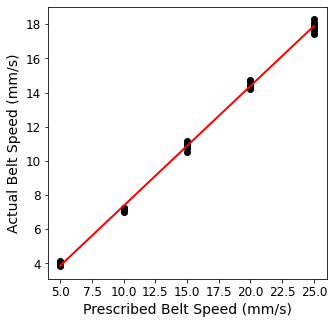

In [18]:
measured_belt_speed = np.array([3.816, 4.068, 4.086, 4.05, 3.906, 4.03, 3.88, 4.15, 7.17, 7.11, 7.128, 7.13, 7.02, 7.074,
                               7.23, 7.21, 11.03, 10.75, 10.9, 11.05, 11.03, 10.98, 11.14, 10.51,
                               14.67, 14.71, 14.26, 14.36, 14.65, 14.34, 14.44, 14.18, 18.288, 17.6, 17.856,
                               17.44, 17.98, 18.072, 18.072, 17.78])
prescribed_belt_speed = np.array([5,5,5,5,5,5,5,5,10,10,10,10,10,10,10,10,15,15,15,15,15,15,15,15,20,20,20,20,20,20,20,20,
                                 25,25,25,25,25,25,25,25])

# compute best fit line
speed_range = np.array([5,10,15,20,25])
m, b = np.polyfit(prescribed_belt_speed, measured_belt_speed, 1)
fit_belt_speed = (m*speed_range) + b

plt.figure(1, figsize = [5,5])
plt.plot(prescribed_belt_speed, measured_belt_speed, color = 'black', linestyle ='none', marker = '.', markersize= 12)
plt.plot(speed_range, fit_belt_speed, color = 'red', linewidth = 2)
plt.xlabel('Prescribed Belt Speed (mm/s)', fontsize = 14)
plt.ylabel('Actual Belt Speed (mm/s)', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)



### Plot Swing Stance Matrices with Filter Frames Overlaid

In [19]:
def plot_swing_stance(cnt, swing_stance_mat, non_walking_indices,fly, trial):
    # plot swing stance
    plt.figure(cnt + 1, figsize=[20,15])
    plt.subplot(2,1,1)
    title = 'Fly ' + str(fly)+ ' Trial '+ str(trial)+ ' Filtered Swing Stance Plot (stance = white; swing = black)'
    plt.title(title, fontsize = 18)
    plt.xlabel('frame number (#)', fontsize = 18)
    plt.ylabel('leg', fontsize = 18)
    labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
    axes = plt.gca()
    axes.set_yticks(np.arange(0, 6, 1))
    axes.set_yticklabels(labels)
    plt.imshow(swing_stance_mat, interpolation = 'none', cmap = 'gray',aspect='auto')

    # filter the swing stance mat
    swing_stance_mat[:, non_walking_indices] = 0.5
    plt.subplot(2,1,2)
    title = 'Filtered Swing Stance Plot (stance = white; swing = black)'
    plt.title(title, fontsize = 18)
    plt.xlabel('frame number (#)', fontsize = 18)
    plt.ylabel('leg', fontsize = 18)
    labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
    axes = plt.gca()
    axes.set_yticks(np.arange(0, 6, 1))
    axes.set_yticklabels(labels)
    plt.imshow(swing_stance_mat, interpolation = 'none', cmap = 'gray',aspect='auto')

### Iteratively compute kinematics

In [22]:
# parameters
FS = 180 # frames per second
nlegs = 6 # number of legs
ntrials = 50 # max number of trials per fly
trial_duration = 10 # seconds
trial_samples = round(FS * trial_duration) # number of frames
nflies_genotype = [[1,16], [16, 32], [1, 15], [1,3], [1, 6], [1, 7]]
genotype_counter = -1 # counter for specifying the number of flies per genotype
percent_walking_threshold = 0.1 # fly is walking 10% of the time
fly_genotypes = ['wt_berlin', 'wt_berlin_halteres', 'wt_cantons'] # 'jr347_tnt', 'jr345_tnt', 'jr345_kir'

# Storage fo kinematic results across genotypes
genotype_meta_matrix = []
genotype_heading_angle = [] 
genotype_total_velocity = []
genotype_parallel_velocity = []
genotype_perpendicular_velocity = []
genotype_step_freq = []
genotype_stride_length = []
genotype_stance_duration = []
genotype_swing_duration = []
genotype_AEPx = []
genotype_AEPy = []
genotype_PEPx = []
genotype_PEPy = []
genotype_phase = []
genotype_conditional_phase = []
genotype_nlegs = []

# iterate through genotypes
for genotype in fly_genotypes:
    print(genotype)
    
    genotype_counter += 1
    # number of flies for genotype
    fly_nums = np.arange(nflies_genotype[genotype_counter][0],nflies_genotype[genotype_counter][1]) # experimental flies
    
    # data and stimulus directories
    data_dir = 'G:/My Drive/Tuthill Lab Shared/Brandon/LB_data/' + genotype + '/pose-3d/'
    data_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
    # sort all the files by fly and trial number
    file_ids = find_file_info(data_files)
    
    stim_dir = 'G:/My Drive/Tuthill Lab Shared/Brandon/LB_data/' + genotype + '/videos-raw/'
    
    cnt = 0 # counter
    
    # Declare variable storage parameters
    # Meta Matrix
    meta_mat = np.zeros((file_ids.shape[0], 3)) 
    
    # Heading
    Heading_Direction = np.empty((file_ids.shape[0],trial_samples))
    Heading_Direction[:] = np.nan   
    
    # Velocity
    # Total velocity
    Total_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Total_Velocity[:] = np.nan
    
    # Walking speed parallel to driving axis
    Parallel_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Parallel_Velocity[:] = np.nan
    
    # Walking speed perpendicular to driving axis
    Perpendicular_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Perpendicular_Velocity[:] = np.nan
    
    # Number of Legs in Stance
    N_LEGS = np.empty((file_ids.shape[0],trial_samples))
    N_LEGS[:] = np.nan
    
    # Step Frequency
    R1_freq = np.empty((file_ids.shape[0],trial_samples))
    R1_freq[:] = np.nan
    R2_freq = np.empty((file_ids.shape[0],trial_samples))
    R2_freq[:] = np.nan
    R3_freq = np.empty((file_ids.shape[0],trial_samples))
    R3_freq[:] = np.nan
    L1_freq = np.empty((file_ids.shape[0],trial_samples))
    L1_freq[:] = np.nan
    L2_freq = np.empty((file_ids.shape[0],trial_samples))
    L2_freq[:] = np.nan
    L3_freq = np.empty((file_ids.shape[0],trial_samples))
    L3_freq[:] = np.nan
    
    # Stride Length
    R1_stride = np.empty((file_ids.shape[0],trial_samples))
    R1_stride[:] = np.nan
    R2_stride = np.empty((file_ids.shape[0],trial_samples))
    R2_stride[:] = np.nan
    R3_stride = np.empty((file_ids.shape[0],trial_samples))
    R3_stride[:] = np.nan
    L1_stride = np.empty((file_ids.shape[0],trial_samples))
    L1_stride[:] = np.nan
    L2_stride = np.empty((file_ids.shape[0],trial_samples))
    L2_stride[:] = np.nan
    L3_stride = np.empty((file_ids.shape[0],trial_samples))
    L3_stride[:] = np.nan
    
    # Stance Duration 
    R1_stance = np.empty((file_ids.shape[0],trial_samples))
    R1_stance[:] = np.nan
    R2_stance = np.empty((file_ids.shape[0],trial_samples))
    R2_stance[:] = np.nan
    R3_stance = np.empty((file_ids.shape[0],trial_samples))
    R3_stance[:] = np.nan
    L1_stance = np.empty((file_ids.shape[0],trial_samples))
    L1_stance[:] = np.nan
    L2_stance = np.empty((file_ids.shape[0],trial_samples))
    L2_stance[:] = np.nan
    L3_stance = np.empty((file_ids.shape[0],trial_samples))
    L3_stance[:] = np.nan
    
    # Swing Duration
    R1_swing = np.empty((file_ids.shape[0],trial_samples))
    R1_swing[:] = np.nan
    R2_swing = np.empty((file_ids.shape[0],trial_samples))
    R2_swing[:] = np.nan
    R3_swing = np.empty((file_ids.shape[0],trial_samples))
    R3_swing[:] = np.nan
    L1_swing = np.empty((file_ids.shape[0],trial_samples))
    L1_swing[:] = np.nan
    L2_swing = np.empty((file_ids.shape[0],trial_samples))
    L2_swing[:] = np.nan
    L3_swing = np.empty((file_ids.shape[0],trial_samples))
    L3_swing[:] = np.nan
    
    # AEP
    R1_AEPx = np.empty((file_ids.shape[0],trial_samples))
    R1_AEPx[:] = np.nan
    R2_AEPx = np.empty((file_ids.shape[0],trial_samples))
    R2_AEPx[:] = np.nan
    R3_AEPx = np.empty((file_ids.shape[0],trial_samples))
    R3_AEPx[:] = np.nan
    L1_AEPx = np.empty((file_ids.shape[0],trial_samples))
    L1_AEPx[:] = np.nan
    L2_AEPx = np.empty((file_ids.shape[0],trial_samples))
    L2_AEPx[:] = np.nan
    L3_AEPx = np.empty((file_ids.shape[0],trial_samples))
    L3_AEPx[:] = np.nan
    
    R1_AEPy = np.empty((file_ids.shape[0],trial_samples))
    R1_AEPy[:] = np.nan
    R2_AEPy = np.empty((file_ids.shape[0],trial_samples))
    R2_AEPy[:] = np.nan
    R3_AEPy = np.empty((file_ids.shape[0],trial_samples))
    R3_AEPy[:] = np.nan
    L1_AEPy = np.empty((file_ids.shape[0],trial_samples))
    L1_AEPy[:] = np.nan
    L2_AEPy = np.empty((file_ids.shape[0],trial_samples))
    L2_AEPy[:] = np.nan
    L3_AEPy = np.empty((file_ids.shape[0],trial_samples))
    L3_AEPy[:] = np.nan
    
    # PEP
    R1_PEPx = np.empty((file_ids.shape[0],trial_samples))
    R1_PEPx[:] = np.nan
    R2_PEPx = np.empty((file_ids.shape[0],trial_samples))
    R2_PEPx[:] = np.nan
    R3_PEPx = np.empty((file_ids.shape[0],trial_samples))
    R3_PEPx[:] = np.nan
    L1_PEPx = np.empty((file_ids.shape[0],trial_samples))
    L1_PEPx[:] = np.nan
    L2_PEPx = np.empty((file_ids.shape[0],trial_samples))
    L2_PEPx[:] = np.nan
    L3_PEPx = np.empty((file_ids.shape[0],trial_samples))
    L3_PEPx[:] = np.nan
    
    R1_PEPy = np.empty((file_ids.shape[0],trial_samples))
    R1_PEPy[:] = np.nan
    R2_PEPy = np.empty((file_ids.shape[0],trial_samples))
    R2_PEPy[:] = np.nan
    R3_PEPy = np.empty((file_ids.shape[0],trial_samples))
    R3_PEPy[:] = np.nan
    L1_PEPy = np.empty((file_ids.shape[0],trial_samples))
    L1_PEPy[:] = np.nan
    L2_PEPy = np.empty((file_ids.shape[0],trial_samples))
    L2_PEPy[:] = np.nan
    L3_PEPy = np.empty((file_ids.shape[0],trial_samples))
    L3_PEPy[:] = np.nan
    
    # Step Velocity
    R1_vel = np.empty((file_ids.shape[0],trial_samples))
    R1_vel[:] = np.nan
    R2_vel = np.empty((file_ids.shape[0],trial_samples))
    R2_vel[:] = np.nan
    R3_vel = np.empty((file_ids.shape[0],trial_samples))
    R3_vel[:] = np.nan
    L1_vel = np.empty((file_ids.shape[0],trial_samples))
    L1_vel[:] = np.nan
    L2_vel = np.empty((file_ids.shape[0],trial_samples))
    L2_vel[:] = np.nan
    L3_vel = np.empty((file_ids.shape[0],trial_samples))
    L3_vel[:] = np.nan
    
    # Phase
    R1_phase = np.empty((file_ids.shape[0],trial_samples))
    R1_phase[:] = np.nan
    R2_phase = np.empty((file_ids.shape[0],trial_samples))
    R2_phase[:] = np.nan
    R3_phase = np.empty((file_ids.shape[0],trial_samples))
    R3_phase[:] = np.nan
    L1_phase = np.empty((file_ids.shape[0],trial_samples))
    L1_phase[:] = np.nan
    L2_phase = np.empty((file_ids.shape[0],trial_samples))
    L2_phase[:] = np.nan
    L3_phase = np.empty((file_ids.shape[0],trial_samples))
    L3_phase[:] = np.nan
    
    # Conditional Phase
    R1_cond_phase = np.empty((file_ids.shape[0],trial_samples))
    R1_cond_phase[:] = np.nan
    R2_cond_phase = np.empty((file_ids.shape[0],trial_samples))
    R2_cond_phase[:] = np.nan
    R3_cond_phase = np.empty((file_ids.shape[0],trial_samples))
    R3_cond_phase[:] = np.nan
    L2_cond_phase = np.empty((file_ids.shape[0],trial_samples))
    L2_cond_phase[:] = np.nan
    L3_cond_phase = np.empty((file_ids.shape[0],trial_samples))
    L3_cond_phase[:] = np.nan
    
    # iterate through flies and trials
    for fly in fly_nums:
        for trial in range(ntrials + 1): # ensure that the range extends to the final file number, i.e. 50
            # find the corresponding data file
            file_idx = np.where(np.logical_and(fly == file_ids[:,0], trial == file_ids[:,1]))[0]
            
            for index in range(len(file_idx)):
                # current filename
                data_filename = data_files[file_idx[index]]
                print(data_filename)
                
                # load stim file
                stim_filename = stim_dir + data_filename[0:-4] + '_Belt_Speed.txt'
                belt_speed = np.median(np.loadtxt(stim_filename))
                
                # extract driving speed for trial info
                driving_speeds = np.array([5, 10, 15, 20, 25])
                speed_idx = np.argmin(np.abs(driving_speeds - belt_speed))
                trial_speed = fit_belt_speed[speed_idx]
             
                # store condition associated with file
                meta_mat[cnt, 0] = fly
                meta_mat[cnt, 1] = trial
                meta_mat[cnt, 2] = trial_speed # driving speed
                     
                # load data associated with current file
                curr_tracked_data = pd.read_csv(data_dir + data_filename)
                                
                # organize the data and normalize the legs relative to the thorax
                [head, thorax, abdomen, x_pos, y_pos, z_pos]=  org_data(curr_tracked_data)

                # Analyze kinematics
                # velocity
                [lin_vel, filt_vel_parallel, filt_vel_perpendicular, heading_angle] = compute_vel(head, thorax, trial_speed)

                # filter walking based on velocity
                non_walking_indices = filter_walking(filt_vel_parallel, head, thorax, abdomen, heading_angle)
                
                # Portion of time that the fly must be walking to analyze kinematics
                if (len(non_walking_indices)/trial_samples) >= percent_walking_threshold:
                    
                    # frames in which the fly is classified as walking
                    all_frames = np.arange(0, trial_samples)
                    walking_indices = np.setdiff1d(all_frames, non_walking_indices)
                    
                    # Estimate the flies body length for normalizing spatial metrics
                    BL = estimate_BL(head, abdomen, walking_indices)

                    # analyze intralimb kinematics and obtain swing stance matrix
                    # stride length
                    [swing_stance_mat, stride_length, stance_start, stance_end, AEPx, AEPy, PEPx, PEPy] = swing_stance(x_pos, y_pos, z_pos, BL)

                    # stance and swing duration, and duty factor 
                    [stance_time_store, stance_duration, swing_time_store, swing_duration, duty_factor] = swing_stance_duration(stance_start, stance_end)

                    # step frequency 
                    step_frequency = compute_step_freq(stance_start)

                    # interlimb coordination
                    # phase signal and conditional phase
                    [phase, conditional_phase] = calculate_phase(x_pos, stance_start)
                    
                    # plot original and filtered swing stance plots
                    #plot_swing_stance(cnt, swing_stance_mat, non_walking_indices, fly, trial)

                    # Fill in storage array with kinematic data
                    # isolate the indices in which the fly is walking
                    # HEADING DIRECTION
                    Heading_Direction[cnt, :] = heading_angle

                    # VELOCITY
                    Total_Velocity[cnt, 1::] = lin_vel
                    Parallel_Velocity[cnt, 1::] = filt_vel_parallel
                    Perpendicular_Velocity[cnt, 1::] = filt_vel_perpendicular
                    
                    # Number of legs in Stance
                    nlegs_stance = np.sum(swing_stance_mat, axis = 0)
                    N_LEGS[cnt, walking_indices] = nlegs_stance[walking_indices]
                    
                    # Intralimb kinematic and interlimb coordination filters
                    [R1_step_index, R1_step_indices, R2_step_index, R2_step_indices, R3_step_index, R3_step_indices,
                    L1_step_index, L1_step_indices, L2_step_index, L2_step_indices, L3_step_index, L3_step_indices,
                    R1_stance_index, R1_stance_indices, R2_stance_index, R2_stance_indices, R3_stance_index, R3_stance_indices,
                    L1_stance_index, L1_stance_indices, L2_stance_index, L2_stance_indices, L3_stance_index, L3_stance_indices,
                    R1_swing_index, R1_swing_indices, R2_swing_index, R2_swing_indices, R3_swing_index, R3_swing_indices,
                    L1_swing_index, L1_swing_indices, L2_swing_index, L2_swing_indices, L3_swing_index, L3_swing_indices] =filter_stance_swing_indices(stance_start, stance_end)

                    # STEP FREQUENCY
                    R1_freq[cnt, R1_step_indices] = step_frequency[0][R1_step_index]
                    R2_freq[cnt, R2_step_indices] = step_frequency[1][R2_step_index] 
                    R3_freq[cnt, R3_step_indices] = step_frequency[2][R3_step_index]
                    L1_freq[cnt, L1_step_indices] = step_frequency[3][L1_step_index]
                    L2_freq[cnt, L2_step_indices] = step_frequency[4][L2_step_index]
                    L3_freq[cnt, L3_step_indices] = step_frequency[5][L3_step_index]

                    # STRIDE LENGTH...actually step amplitude
                    R1_stride[cnt, R1_swing_indices] = stride_length[0][R1_swing_index]
                    R2_stride[cnt, R2_swing_indices] = stride_length[1][R2_swing_index] 
                    R3_stride[cnt, R3_swing_indices] = stride_length[2][R3_swing_index]
                    L1_stride[cnt, L1_swing_indices] = stride_length[3][L1_swing_index]
                    L2_stride[cnt, L2_swing_indices] = stride_length[4][L2_swing_index]
                    L3_stride[cnt, L3_swing_indices] = stride_length[5][L3_swing_index]

                    # STANCE DURATION
                    R1_stance[cnt, R1_stance_indices] = stance_duration[0][R1_stance_index]
                    R2_stance[cnt, R2_stance_indices] = stance_duration[1][R2_stance_index] 
                    R3_stance[cnt, R3_stance_indices] = stance_duration[2][R3_stance_index]
                    L1_stance[cnt, L1_stance_indices] = stance_duration[3][L1_stance_index]
                    L2_stance[cnt, L2_stance_indices] = stance_duration[4][L2_stance_index]
                    L3_stance[cnt, L3_stance_indices] = stance_duration[5][L3_stance_index]

                    # SWING DURATION
                    R1_swing[cnt, R1_swing_indices] = swing_duration[0][R1_swing_index]
                    R2_swing[cnt, R2_swing_indices] = swing_duration[1][R2_swing_index] 
                    R3_swing[cnt, R3_swing_indices] = swing_duration[2][R3_swing_index]
                    L1_swing[cnt, L1_swing_indices] = swing_duration[3][L1_swing_index]
                    L2_swing[cnt, L2_swing_indices] = swing_duration[4][L2_swing_index]
                    L3_swing[cnt, L3_swing_indices] = swing_duration[5][L3_swing_index]

                    # AEP
                    R1_AEPx[cnt, R1_stance_indices] = AEPx[0][R1_stance_index]
                    R2_AEPx[cnt, R2_stance_indices] = AEPx[1][R2_stance_index] 
                    R3_AEPx[cnt, R3_stance_indices] = AEPx[2][R3_stance_index]
                    L1_AEPx[cnt, L1_stance_indices] = AEPx[3][L1_stance_index]
                    L2_AEPx[cnt, L2_stance_indices] = AEPx[4][L2_stance_index]
                    L3_AEPx[cnt, L3_stance_indices] = AEPx[5][L3_stance_index]

                    R1_AEPy[cnt, R1_stance_indices] = AEPy[0][R1_stance_index]
                    R2_AEPy[cnt, R2_stance_indices] = AEPy[1][R2_stance_index] 
                    R3_AEPy[cnt, R3_stance_indices] = AEPy[2][R3_stance_index]
                    L1_AEPy[cnt, L1_stance_indices] = AEPy[3][L1_stance_index]
                    L2_AEPy[cnt, L2_stance_indices] = AEPy[4][L2_stance_index]
                    L3_AEPy[cnt, L3_stance_indices] = AEPy[5][L3_stance_index]

                    # PEP
                    R1_PEPx[cnt, R1_stance_indices] = PEPx[0][R1_stance_index]
                    R2_PEPx[cnt, R2_stance_indices] = PEPx[1][R2_stance_index] 
                    R3_PEPx[cnt, R3_stance_indices] = PEPx[2][R3_stance_index]
                    L1_PEPx[cnt, L1_stance_indices] = PEPx[3][L1_stance_index]
                    L2_PEPx[cnt, L2_stance_indices] = PEPx[4][L2_stance_index]
                    L3_PEPx[cnt, L3_stance_indices] = PEPx[5][L3_stance_index]

                    R1_PEPy[cnt, R1_stance_indices] = PEPy[0][R1_stance_index]
                    R2_PEPy[cnt, R2_stance_indices] = PEPy[1][R2_stance_index] 
                    R3_PEPy[cnt, R3_stance_indices] = PEPy[2][R3_stance_index]
                    L1_PEPy[cnt, L1_stance_indices] = PEPy[3][L1_stance_index]
                    L2_PEPy[cnt, L2_stance_indices] = PEPy[4][L2_stance_index]
                    L3_PEPy[cnt, L3_stance_indices] = PEPy[5][L3_stance_index]

                    # PHASE
                    R1_phase[cnt, walking_indices] = phase[0][walking_indices]
                    R2_phase[cnt, walking_indices] = phase[1][walking_indices] 
                    R3_phase[cnt, walking_indices] = phase[2][walking_indices]
                    L1_phase[cnt, walking_indices] = phase[3][walking_indices]
                    L2_phase[cnt, walking_indices] = phase[4][walking_indices]
                    L3_phase[cnt, walking_indices] = phase[5][walking_indices]

                    # CONDITIONAL PHASE
                    R1_cond_phase[cnt, L1_stance_indices] = conditional_phase[0][L1_stance_index]
                    R2_cond_phase[cnt, L1_stance_indices] = conditional_phase[1][L1_stance_index]
                    R3_cond_phase[cnt, L1_stance_indices] = conditional_phase[2][L1_stance_index]
                    L2_cond_phase[cnt, L1_stance_indices] = conditional_phase[3][L1_stance_index]
                    L3_cond_phase[cnt, L1_stance_indices] = conditional_phase[4][L1_stance_index]

                    cnt += 1 # iterate counter
                else:
                    cnt += 1 # iterate counter
                  
    # Store results for each genotype
    genotype_meta_matrix.append(meta_mat)
    genotype_heading_angle.append(Heading_Direction)
    genotype_total_velocity.append(Total_Velocity)
    genotype_parallel_velocity.append(Parallel_Velocity)
    genotype_perpendicular_velocity.append(Perpendicular_Velocity)
    genotype_step_freq.append([R1_freq, R2_freq, R3_freq, L1_freq, L2_freq, L3_freq])
    genotype_stride_length.append([R1_stride, R2_stride, R3_stride, L1_stride, L2_stride, L3_stride])
    genotype_stance_duration.append([R1_stance, R2_stance, R3_stance, L1_stance, L2_stance, L3_stance])
    genotype_swing_duration.append([R1_swing, R2_swing, R3_swing, L1_swing, L2_swing, L3_swing])
    genotype_AEPx.append([R1_AEPx, R2_AEPx, R3_AEPx, L1_AEPx, L2_AEPx, L3_AEPx])
    genotype_AEPy.append([R1_AEPy, R2_AEPy, R3_AEPy, L1_AEPy, L2_AEPy, L3_AEPy])
    genotype_PEPx.append([R1_PEPx, R2_PEPx, R3_PEPx, L1_PEPx, L2_PEPx, L3_PEPx])
    genotype_PEPy.append([R1_PEPy, R2_PEPy, R3_PEPy, L1_PEPy, L2_PEPy, L3_PEPy])
    genotype_phase.append([R1_phase, R2_phase, R3_phase, L1_phase, L2_phase, L3_phase])
    genotype_conditional_phase.append([R1_cond_phase, R2_cond_phase, R3_cond_phase, L2_cond_phase, L3_cond_phase])
    genotype_nlegs.append(N_LEGS)
    
# Save the results to numpy files
save_dir = 'C:/Users/pratt/Desktop/Analysis/speed_dependent_locomotion/'
np.save(save_dir + 'meta_matrix.npy', genotype_meta_matrix)
np.save(save_dir + 'heading_angle.npy', genotype_heading_angle)
np.save(save_dir + 'total_velocity.npy', genotype_total_velocity)
np.save(save_dir + 'parallel_velocity.npy', genotype_parallel_velocity)
np.save(save_dir + 'perpendicular_velocity.npy', genotype_perpendicular_velocity)
np.save(save_dir + 'step_frequency.npy', genotype_step_freq)
np.save(save_dir + 'stride_length.npy', genotype_stride_length)
np.save(save_dir + 'stance_duration.npy', genotype_stance_duration)
np.save(save_dir + 'swing_duration.npy', genotype_swing_duration)
np.save(save_dir + 'AEPx.npy', genotype_AEPx)
np.save(save_dir + 'AEPy.npy', genotype_AEPy)
np.save(save_dir + 'PEPx.npy', genotype_PEPx)
np.save(save_dir + 'PEPy.npy', genotype_PEPy)
np.save(save_dir + 'phase.npy', genotype_phase)
np.save(save_dir + 'conditional_phase.npy', genotype_conditional_phase)
np.save(save_dir + 'number_legs_stance.npy', genotype_nlegs)


wt_berlin
fly1_Speed_25_Trial_1.csv
fly1_Speed_20_Trial_2.csv
fly1_Speed_20_Trial_3.csv
fly1_Speed_10_Trial_4.csv
fly1_Speed_15_Trial_5.csv
fly1_Speed_10_Trial_6.csv
fly1_Speed_15_Trial_7.csv
fly1_Speed_25_Trial_8.csv
fly1_Speed_10_Trial_9.csv
fly1_Speed_10_Trial_10.csv
fly1_Speed_5_Trial_11.csv
fly1_Speed_10_Trial_12.csv
fly1_Speed_5_Trial_13.csv
fly1_Speed_20_Trial_14.csv
fly1_Speed_15_Trial_15.csv
fly1_Speed_15_Trial_16.csv
fly1_Speed_25_Trial_17.csv
fly1_Speed_5_Trial_18.csv
fly1_Speed_15_Trial_19.csv
fly1_Speed_5_Trial_21.csv
fly1_Speed_25_Trial_22.csv
fly1_Speed_5_Trial_23.csv
fly1_Speed_25_Trial_24.csv
fly1_Speed_10_Trial_25.csv
fly1_Speed_15_Trial_26.csv
fly1_Speed_20_Trial_27.csv
fly1_Speed_25_Trial_28.csv
fly1_Speed_15_Trial_29.csv
fly1_Speed_20_Trial_30.csv
fly1_Speed_5_Trial_31.csv
fly1_Speed_5_Trial_32.csv
fly1_Speed_10_Trial_33.csv
fly2_Speed_15_Trial_1.csv
fly2_Speed_15_Trial_2.csv
fly2_Speed_25_Trial_3.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_20_Trial_4.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_5_Trial_5.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_5_Trial_6.csv
fly2_Speed_20_Trial_7.csv
fly2_Speed_5_Trial_8.csv
fly2_Speed_10_Trial_9.csv
fly2_Speed_10_Trial_10.csv
fly2_Speed_20_Trial_11.csv
fly2_Speed_5_Trial_12.csv
fly2_Speed_15_Trial_13.csv
fly2_Speed_5_Trial_14.csv
fly2_Speed_10_Trial_15.csv
fly2_Speed_10_Trial_16.csv
fly2_Speed_15_Trial_17.csv
fly2_Speed_10_Trial_18.csv
fly2_Speed_5_Trial_19.csv
fly2_Speed_15_Trial_20.csv
fly2_Speed_5_Trial_21.csv
fly2_Speed_10_Trial_22.csv
fly2_Speed_10_Trial_23.csv
fly2_Speed_20_Trial_24.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_5_Trial_25.csv
fly2_Speed_15_Trial_26.csv
fly2_Speed_25_Trial_27.csv
fly2_Speed_10_Trial_28.csv
fly2_Speed_25_Trial_29.csv
fly2_Speed_20_Trial_30.csv
fly2_Speed_25_Trial_31.csv
fly2_Speed_20_Trial_32.csv
fly2_Speed_5_Trial_33.csv
fly2_Speed_15_Trial_34.csv
fly2_Speed_15_Trial_35.csv
fly2_Speed_25_Trial_36.csv
fly2_Speed_25_Trial_37.csv
fly2_Speed_20_Trial_38.csv
fly2_Speed_10_Trial_39.csv
fly2_Speed_20_Trial_40.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_25_Trial_41.csv
fly2_Speed_20_Trial_42.csv
fly2_Speed_5_Trial_43.csv
fly2_Speed_25_Trial_44.csv
fly2_Speed_25_Trial_45.csv
fly2_Speed_15_Trial_46.csv
fly2_Speed_15_Trial_47.csv
fly2_Speed_25_Trial_48.csv
fly2_Speed_20_Trial_49.csv
fly2_Speed_10_Trial_50.csv
fly3_Speed_10_Trial_1.csv
fly3_Speed_15_Trial_2.csv
fly3_Speed_20_Trial_3.csv
fly3_Speed_5_Trial_4.csv
fly3_Speed_20_Trial_5.csv
fly3_Speed_25_Trial_6.csv
fly3_Speed_15_Trial_7.csv
fly3_Speed_25_Trial_8.csv
fly3_Speed_25_Trial_9.csv
fly3_Speed_10_Trial_10.csv
fly3_Speed_5_Trial_11.csv
fly3_Speed_10_Trial_12.csv
fly3_Speed_20_Trial_13.csv
fly3_Speed_15_Trial_14.csv
fly3_Speed_10_Trial_15.csv
fly3_Speed_25_Trial_16.csv
fly3_Speed_5_Trial_17.csv
fly3_Speed_5_Trial_18.csv
fly3_Speed_15_Trial_19.csv
fly3_Speed_10_Trial_20.csv
fly3_Speed_25_Trial_21.csv
fly3_Speed_15_Trial_22.csv
fly3_Speed_25_Trial_23.csv
fly3_Speed_5_Trial_24.csv
fly3_Speed_15_Trial_25.csv
fly3_Speed_15_Trial_26.csv
fly3_Speed_15_Trial_27.csv
fly3_Speed_20_Tr

fly9_Speed_20_Trial_43.csv
fly9_Speed_20_Trial_44.csv
fly9_Speed_25_Trial_45.csv
fly9_Speed_20_Trial_46.csv
fly9_Speed_5_Trial_47.csv
fly9_Speed_5_Trial_48.csv
fly9_Speed_15_Trial_49.csv
fly9_Speed_5_Trial_50.csv
fly10_Speed_5_Trial_1.csv
fly10_Speed_5_Trial_2.csv
fly10_Speed_20_Trial_3.csv
fly10_Speed_5_Trial_4.csv
fly10_Speed_5_Trial_5.csv
fly10_Speed_25_Trial_6.csv
fly10_Speed_15_Trial_7.csv
fly10_Speed_5_Trial_8.csv
fly10_Speed_10_Trial_9.csv
fly10_Speed_10_Trial_10.csv
fly10_Speed_25_Trial_11.csv
fly10_Speed_5_Trial_12.csv
fly10_Speed_10_Trial_13.csv
fly10_Speed_20_Trial_14.csv
fly10_Speed_10_Trial_15.csv
fly10_Speed_25_Trial_16.csv
fly10_Speed_15_Trial_17.csv
fly10_Speed_25_Trial_18.csv
fly10_Speed_10_Trial_19.csv
fly10_Speed_15_Trial_20.csv
fly10_Speed_20_Trial_21.csv
fly10_Speed_10_Trial_22.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly10_Speed_5_Trial_23.csv
fly10_Speed_15_Trial_24.csv
fly10_Speed_15_Trial_25.csv
fly10_Speed_25_Trial_26.csv
fly10_Speed_5_Trial_27.csv
fly10_Speed_10_Trial_28.csv
fly10_Speed_15_Trial_29.csv
fly10_Speed_5_Trial_30.csv
fly10_Speed_10_Trial_31.csv
fly10_Speed_20_Trial_32.csv
fly10_Speed_15_Trial_33.csv
fly10_Speed_20_Trial_34.csv
fly10_Speed_10_Trial_35.csv
fly10_Speed_25_Trial_36.csv
fly10_Speed_15_Trial_37.csv
fly10_Speed_20_Trial_38.csv
fly10_Speed_20_Trial_39.csv
fly10_Speed_25_Trial_40.csv
fly10_Speed_15_Trial_41.csv
fly10_Speed_5_Trial_42.csv
fly10_Speed_25_Trial_43.csv
fly10_Speed_15_Trial_44.csv
fly10_Speed_20_Trial_45.csv
fly10_Speed_20_Trial_46.csv
fly10_Speed_25_Trial_47.csv
fly10_Speed_10_Trial_48.csv
fly10_Speed_25_Trial_49.csv
fly10_Speed_20_Trial_50.csv
fly11_Speed_25_Trial_1.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly11_Speed_20_Trial_2.csv
fly11_Speed_10_Trial_3.csv
fly11_Speed_25_Trial_4.csv
fly11_Speed_5_Trial_5.csv
fly11_Speed_10_Trial_6.csv
fly11_Speed_5_Trial_7.csv
fly11_Speed_25_Trial_8.csv
fly11_Speed_10_Trial_9.csv
fly11_Speed_10_Trial_10.csv
fly11_Speed_15_Trial_11.csv
fly11_Speed_20_Trial_12.csv
fly11_Speed_15_Trial_13.csv
fly11_Speed_15_Trial_14.csv
fly11_Speed_20_Trial_15.csv
fly12_Speed_10_Trial_1.csv
fly12_Speed_20_Trial_2.csv
fly12_Speed_15_Trial_3.csv
fly12_Speed_20_Trial_4.csv
fly12_Speed_15_Trial_5.csv
fly12_Speed_5_Trial_6.csv
fly12_Speed_20_Trial_7.csv
fly12_Speed_10_Trial_8.csv
fly12_Speed_25_Trial_9.csv
fly12_Speed_10_Trial_10.csv
fly12_Speed_25_Trial_11.csv
fly12_Speed_25_Trial_12.csv
fly12_Speed_20_Trial_13.csv
fly12_Speed_25_Trial_14.csv
fly12_Speed_5_Trial_15.csv
fly12_Speed_25_Trial_16.csv
fly12_Speed_15_Trial_17.csv
fly12_Speed_15_Trial_18.csv
fly12_Speed_10_Trial_19.csv
fly12_Speed_5_Trial_20.csv
fly12_Speed_20_Trial_21.csv
fly12_Speed_25_Trial_22.csv
fly13_Speed_20

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly13_Speed_15_Trial_25.csv
fly13_Speed_15_Trial_26.csv
fly13_Speed_10_Trial_27.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly13_Speed_25_Trial_28.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly13_Speed_10_Trial_29.csv
fly13_Speed_20_Trial_30.csv
fly13_Speed_10_Trial_31.csv
fly13_Speed_10_Trial_32.csv
fly13_Speed_25_Trial_33.csv
fly13_Speed_15_Trial_34.csv
fly14_Speed_25_Trial_1.csv
fly14_Speed_10_Trial_2.csv
fly14_Speed_5_Trial_3.csv
fly14_Speed_25_Trial_4.csv
fly14_Speed_5_Trial_5.csv
fly14_Speed_20_Trial_6.csv
fly14_Speed_20_Trial_7.csv
fly14_Speed_20_Trial_8.csv
fly14_Speed_10_Trial_9.csv
fly14_Speed_15_Trial_10.csv
fly14_Speed_20_Trial_11.csv
fly14_Speed_10_Trial_12.csv
fly14_Speed_5_Trial_13.csv
fly14_Speed_10_Trial_14.csv
fly14_Speed_25_Trial_15.csv
fly14_Speed_20_Trial_16.csv
fly14_Speed_25_Trial_17.csv
fly14_Speed_5_Trial_18.csv
fly14_Speed_10_Trial_19.csv
fly15_Speed_20_Trial_1.csv
fly15_Speed_20_Trial_2.csv
fly15_Speed_25_Trial_3.csv
fly15_Speed_5_Trial_4.csv
fly15_Speed_15_Trial_5.csv
fly15_Speed_15_Trial_6.csv
fly15_Speed_5_Trial_7.csv
fly15_Speed_15_Trial_8.csv
fly15_Speed_20_Trial_9.csv
fly15_Speed_10_Trial_10.csv
fly15_Speed_10_Trial_11.csv
fly15_Speed_20_T

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_20_Trial_20.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_15_Trial_21.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_25_Trial_22.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_5_Trial_23.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_15_Trial_24.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly20_Speed_10_Trial_25.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly21_Speed_10_Trial_1.csv
fly21_Speed_25_Trial_2.csv
fly21_Speed_25_Trial_3.csv
fly21_Speed_5_Trial_4.csv
fly21_Speed_5_Trial_5.csv
fly21_Speed_10_Trial_6.csv
fly21_Speed_10_Trial_7.csv
fly21_Speed_25_Trial_8.csv
fly21_Speed_15_Trial_9.csv
fly21_Speed_15_Trial_10.csv
fly21_Speed_25_Trial_11.csv
fly21_Speed_5_Trial_12.csv
fly21_Speed_20_Trial_13.csv
fly21_Speed_25_Trial_14.csv
fly21_Speed_5_Trial_15.csv
fly21_Speed_10_Trial_16.csv
fly21_Speed_15_Trial_17.csv
fly21_Speed_10_Trial_18.csv
fly21_Speed_15_Trial_19.csv
fly21_Speed_20_Trial_20.csv
fly21_Speed_15_Trial_21.csv
fly21_Speed_20_Trial_22.csv
fly21_Speed_20_Trial_23.csv
fly21_Speed_5_Trial_24.csv
fly21_Speed_20_Trial_25.csv
fly22_Speed_20_Trial_1.csv
fly22_Speed_25_Trial_2.csv
fly22_Speed_5_Trial_3.csv
fly22_Speed_15_Trial_4.csv
fly22_Speed_20_Trial_5.csv
fly22_Speed_15_Trial_6.csv
fly22_Speed_15_Trial_7.csv
fly22_Speed_20_Trial_8.csv
fly22_Speed_10_Trial_9.csv
fly22_Speed_5_Trial_10.csv
fly22_Speed_15_Trial_11.csv
fly22_Speed_10_Tr

fly2_Speed_20_Trial_5.csv
fly2_Speed_15_Trial_6.csv
fly2_Speed_10_Trial_7.csv
fly2_Speed_25_Trial_8.csv
fly2_Speed_5_Trial_9.csv
fly2_Speed_15_Trial_10.csv
fly2_Speed_20_Trial_11.csv
fly2_Speed_10_Trial_12.csv
fly2_Speed_15_Trial_13.csv
fly2_Speed_5_Trial_14.csv
fly2_Speed_25_Trial_15.csv
fly2_Speed_25_Trial_16.csv
fly2_Speed_20_Trial_17.csv
fly2_Speed_10_Trial_18.csv
fly2_Speed_5_Trial_19.csv
fly2_Speed_20_Trial_20.csv
fly2_Speed_10_Trial_21.csv
fly2_Speed_20_Trial_22.csv
fly2_Speed_15_Trial_23.csv
fly2_Speed_20_Trial_24.csv
fly2_Speed_15_Trial_25.csv
fly2_Speed_5_Trial_26.csv
fly2_Speed_5_Trial_27.csv
fly2_Speed_15_Trial_28.csv
fly2_Speed_10_Trial_29.csv
fly2_Speed_25_Trial_30.csv
fly2_Speed_25_Trial_31.csv
fly2_Speed_20_Trial_32.csv
fly2_Speed_10_Trial_33.csv
fly2_Speed_20_Trial_34.csv
fly2_Speed_20_Trial_35.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly2_Speed_25_Trial_36.csv
fly2_Speed_25_Trial_37.csv
fly2_Speed_25_Trial_38.csv
fly2_Speed_15_Trial_39.csv
fly2_Speed_25_Trial_40.csv
fly2_Speed_20_Trial_41.csv
fly2_Speed_15_Trial_42.csv
fly2_Speed_5_Trial_43.csv
fly2_Speed_5_Trial_44.csv
fly2_Speed_10_Trial_45.csv
fly2_Speed_10_Trial_46.csv
fly2_Speed_10_Trial_47.csv
fly2_Speed_10_Trial_48.csv
fly2_Speed_5_Trial_49.csv
fly2_Speed_15_Trial_50.csv
fly3_Speed_20_Trial_1.csv
fly3_Speed_20_Trial_2.csv
fly3_Speed_15_Trial_3.csv
fly3_Speed_5_Trial_4.csv
fly3_Speed_25_Trial_5.csv
fly3_Speed_25_Trial_6.csv
fly3_Speed_5_Trial_7.csv
fly3_Speed_10_Trial_8.csv
fly3_Speed_10_Trial_9.csv
fly3_Speed_10_Trial_10.csv
fly3_Speed_5_Trial_11.csv
fly3_Speed_10_Trial_12.csv
fly3_Speed_15_Trial_13.csv
fly3_Speed_15_Trial_14.csv
fly3_Speed_10_Trial_15.csv
fly3_Speed_25_Trial_16.csv
fly3_Speed_25_Trial_17.csv
fly3_Speed_10_Trial_18.csv
fly3_Speed_5_Trial_19.csv
fly3_Speed_15_Trial_20.csv
fly3_Speed_15_Trial_21.csv
fly3_Speed_20_Trial_22.csv
fly3_Speed_25_Tri

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly4_Speed_20_Trial_28.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly4_Speed_15_Trial_29.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly4_Speed_5_Trial_30.csv
fly4_Speed_25_Trial_31.csv
fly4_Speed_5_Trial_32.csv
fly4_Speed_10_Trial_33.csv
fly4_Speed_25_Trial_34.csv
fly4_Speed_15_Trial_35.csv
fly4_Speed_25_Trial_36.csv
fly4_Speed_20_Trial_37.csv
fly4_Speed_15_Trial_38.csv
fly4_Speed_10_Trial_39.csv
fly4_Speed_5_Trial_40.csv
fly4_Speed_10_Trial_41.csv
fly4_Speed_25_Trial_42.csv
fly4_Speed_15_Trial_43.csv
fly4_Speed_15_Trial_44.csv
fly4_Speed_10_Trial_45.csv
fly4_Speed_20_Trial_46.csv
fly4_Speed_20_Trial_47.csv
fly4_Speed_15_Trial_48.csv
fly4_Speed_5_Trial_49.csv
fly4_Speed_20_Trial_50.csv
fly5_Speed_25_Trial_1.csv
fly5_Speed_15_Trial_2.csv
fly5_Speed_5_Trial_3.csv
fly5_Speed_25_Trial_4.csv
fly5_Speed_10_Trial_5.csv
fly5_Speed_5_Trial_6.csv
fly5_Speed_15_Trial_7.csv
fly5_Speed_15_Trial_8.csv
fly5_Speed_20_Trial_9.csv
fly5_Speed_10_Trial_10.csv
fly5_Speed_15_Trial_11.csv
fly5_Speed_20_Trial_12.csv
fly5_Speed_5_Trial_13.csv
fly5_Speed_25_Trial_14.csv
fly5_Speed_20_Trial_15.csv
fly5_Speed_5_Trial_16.csv
fly5_Speed_20_Tria

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly10_Speed_15_Trial_2.csv
fly10_Speed_10_Trial_3.csv
fly10_Speed_15_Trial_4.csv
fly10_Speed_15_Trial_5.csv
fly10_Speed_20_Trial_6.csv
fly10_Speed_5_Trial_7.csv
fly10_Speed_10_Trial_8.csv
fly10_Speed_20_Trial_9.csv
fly10_Speed_10_Trial_10.csv
fly10_Speed_10_Trial_11.csv
fly10_Speed_25_Trial_12.csv
fly10_Speed_25_Trial_13.csv
fly10_Speed_20_Trial_14.csv
fly10_Speed_15_Trial_15.csv
fly10_Speed_20_Trial_16.csv
fly10_Speed_15_Trial_17.csv
fly10_Speed_15_Trial_18.csv
fly10_Speed_10_Trial_19.csv
fly10_Speed_10_Trial_20.csv
fly10_Speed_25_Trial_21.csv
fly10_Speed_20_Trial_22.csv
fly10_Speed_25_Trial_23.csv
fly10_Speed_20_Trial_24.csv
fly10_Speed_5_Trial_25.csv
fly10_Speed_10_Trial_26.csv
fly10_Speed_20_Trial_27.csv
fly10_Speed_10_Trial_28.csv
fly10_Speed_5_Trial_29.csv
fly10_Speed_20_Trial_30.csv
fly10_Speed_20_Trial_31.csv
fly10_Speed_15_Trial_32.csv
fly10_Speed_5_Trial_33.csv
fly10_Speed_25_Trial_34.csv
fly10_Speed_15_Trial_35.csv
fly10_Speed_25_Trial_36.csv
fly10_Speed_5_Trial_37.csv
fly10

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly11_Speed_5_Trial_38.csv
fly11_Speed_15_Trial_39.csv
fly11_Speed_25_Trial_40.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly11_Speed_20_Trial_41.csv
fly11_Speed_15_Trial_42.csv
fly11_Speed_15_Trial_43.csv
fly11_Speed_20_Trial_44.csv
fly11_Speed_20_Trial_45.csv
fly11_Speed_15_Trial_46.csv
fly11_Speed_20_Trial_47.csv
fly11_Speed_15_Trial_48.csv
fly11_Speed_20_Trial_49.csv
fly11_Speed_20_Trial_50.csv
fly12_Speed_20_Trial_1.csv
fly12_Speed_10_Trial_2.csv
fly12_Speed_15_Trial_3.csv
fly12_Speed_10_Trial_4.csv
fly12_Speed_20_Trial_5.csv
fly12_Speed_10_Trial_6.csv
fly12_Speed_5_Trial_7.csv
fly12_Speed_25_Trial_8.csv
fly12_Speed_5_Trial_9.csv
fly12_Speed_25_Trial_10.csv
fly12_Speed_5_Trial_11.csv
fly12_Speed_15_Trial_12.csv
fly12_Speed_25_Trial_13.csv
fly12_Speed_10_Trial_14.csv
fly12_Speed_5_Trial_15.csv
fly12_Speed_5_Trial_16.csv
fly12_Speed_15_Trial_17.csv
fly12_Speed_25_Trial_18.csv
fly12_Speed_15_Trial_19.csv
fly12_Speed_10_Trial_20.csv
fly12_Speed_15_Trial_21.csv
fly12_Speed_15_Trial_22.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_5_Trial_23.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_10_Trial_24.csv
fly12_Speed_5_Trial_25.csv
fly12_Speed_15_Trial_26.csv
fly12_Speed_20_Trial_27.csv
fly12_Speed_10_Trial_28.csv
fly12_Speed_15_Trial_29.csv
fly12_Speed_25_Trial_30.csv
fly12_Speed_25_Trial_31.csv
fly12_Speed_25_Trial_32.csv
fly12_Speed_10_Trial_33.csv
fly12_Speed_5_Trial_34.csv
fly12_Speed_15_Trial_35.csv
fly12_Speed_20_Trial_36.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_20_Trial_37.csv
fly12_Speed_20_Trial_38.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_25_Trial_39.csv
fly12_Speed_20_Trial_40.csv
fly12_Speed_20_Trial_41.csv
fly12_Speed_10_Trial_42.csv
fly12_Speed_20_Trial_43.csv
fly12_Speed_25_Trial_44.csv
fly12_Speed_15_Trial_45.csv
fly12_Speed_25_Trial_46.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_5_Trial_47.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_5_Trial_48.csv


C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


fly12_Speed_20_Trial_49.csv
fly12_Speed_10_Trial_50.csv
fly13_Speed_15_Trial_1.csv
fly13_Speed_20_Trial_2.csv
fly13_Speed_20_Trial_3.csv
fly13_Speed_15_Trial_4.csv
fly13_Speed_20_Trial_5.csv
fly13_Speed_15_Trial_6.csv
fly13_Speed_20_Trial_7.csv
fly13_Speed_20_Trial_8.csv
fly13_Speed_5_Trial_9.csv
fly13_Speed_5_Trial_10.csv
fly13_Speed_25_Trial_11.csv
fly13_Speed_10_Trial_12.csv
fly13_Speed_20_Trial_13.csv
fly13_Speed_15_Trial_14.csv
fly13_Speed_20_Trial_15.csv
fly13_Speed_15_Trial_16.csv
fly13_Speed_10_Trial_17.csv
fly13_Speed_15_Trial_18.csv
fly13_Speed_10_Trial_19.csv
fly13_Speed_25_Trial_20.csv
fly13_Speed_25_Trial_21.csv
fly13_Speed_5_Trial_22.csv
fly13_Speed_15_Trial_23.csv
fly13_Speed_25_Trial_24.csv
fly13_Speed_5_Trial_25.csv
fly13_Speed_20_Trial_26.csv
fly13_Speed_5_Trial_27.csv
fly13_Speed_10_Trial_28.csv
fly13_Speed_5_Trial_29.csv
fly13_Speed_10_Trial_30.csv
fly13_Speed_10_Trial_31.csv
fly13_Speed_25_Trial_32.csv
fly13_Speed_15_Trial_33.csv
fly13_Speed_5_Trial_34.csv
fly13_Sp

C:\Users\pratt\Anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
